# Bayesian Naive Bayes

Gregory Schuit   
16636910  
IIC3695 - Tópicos Avanzados de Inteligencia de Máquina

## Naive Bayes Clásico
En general, un algoritmo de clasificación consiste en maximizar la probabilidad de "y", dada las features y los datos (i.e. p(y|x,D)), es decir, la clase que se escogerá para un dato desconocido, vendrá dada por aquella que maximice p(y|x, D). Sin embargo, como esta probabilidad es difícil de calcular ocupando la regla clásica de bayes, lo que se hace es asumir independencia entre las features, dada la clase. Esto puede expresarse como sigue:

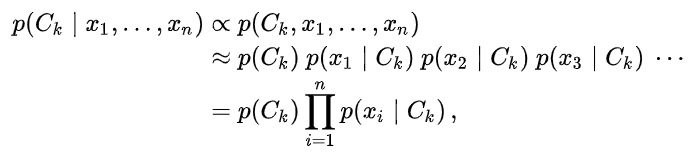

Ya que estamos maximizando, podemos ignorar el factor de normalización y reemplazar la igualdad por una relación de proporcionalidad.  

Dada esta fórmula, solamente nos queda preguntarnos cómo distribuyen las clases dado los datos, y cómo distribuyen las features dada la clase, y dado los datos. Para el caso de la variable aleatorea de la clase, podemos ver facilmente que, al ser categórica, necesitamos modelarla con una distribución multinomial. Por otra parte, las features podrían tomar cualquier distribución dependiendo de su naturaleza. Sin embargo, como en esta tarea tenemos features que estan discretizadas, optaremos por modelarlas tambien como si fuesen variables categóricas, es decir, con una multinomial.

Dicho esto, recordemos que la distribucion multinomial se define según la siguiente probabilidad conjunta:

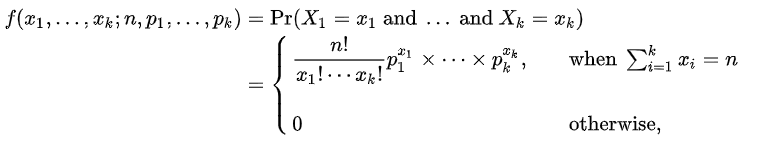

Ahora bien, como sabemos que un dato solo puede ser de una clase a la vez, y tomando a $p$ como la variable de la función, obtenemos que la likelihood relaciona un dato $x_1$ con su probabilidad respectiva $p_1$ directamente. Si aplicamos este razonamiento al problema en cuestión, podemos ver que la probabilidad $p(y=c)$ es igual a $p_c$, con $p_c$ igual a la probabilidad frecuentista del evento extraída de los datos. En palabras simples, para calcular la probabilidad de una clase, solo basta con contar casos favorables en la base de datos, y dividirlo en la cantidad de datos.

Análogamente, como las probabilidades $P(x_i | y=c)$ tambien distribuyen multinomial, aplicamos el mismo razonamiento para concluir que la probabilidad de que la feature $x_i$ sea igual a un valor específico $x_0$ dada la clase, es igual a la cantidad de datos que cumplen con que la feature $x_i$ sea $x_0$, dividido en la cantidad de datos en los que su clase es $y=c$.

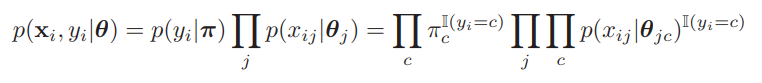

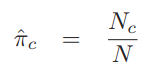

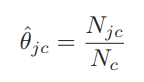

En conclusión, para implementar el algoritmo de Naive Bayes con estos datos categóricos, procederemos a contar todas las posibles clases, y todas las posibles features, registrando su frecuencia y factores de normalización para calcular las probabilidades de cada término, y finalmente llegar a la distribución de probabilidades para la predicción de $y$.

## Bayesian Naive Bayes

Si queremos hace Naive Bayes de manera Bayesiana, debemos condicionar todas las probabilidades del algoritmo con respecto a sus respectivos parámetros, multiplicar por la probabilidad del parámetro, y luego integrar sobre todos los posibles paramámetros. A esto se le llama posterior predictiva.

Dado que las probabilidades del algoritmo vienen de una distribución multinomial, nos combiene ocupar distribuciones Dirichlet como priors. Notar que, si tenemos $n$ features, tendremos $n + 1$ probabilidades y $n + 1$ Dirichlets (i.e. una para cada feature y una para la clase "y"). Esto se justifica porque la Dirichlet funciona como conjugado de la Likelihood Multinomial.

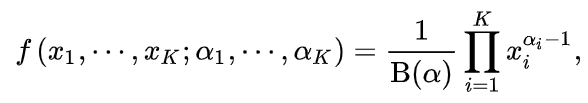

Luego de multiplicar la dirichlet con la multnomial, ocurre que la integral puede resolverse ya que representa la esperanza de una nueva dirichlet, obteniéndose el siguiente resultado (luego de varios pasos de álgebra y cambios de variables)

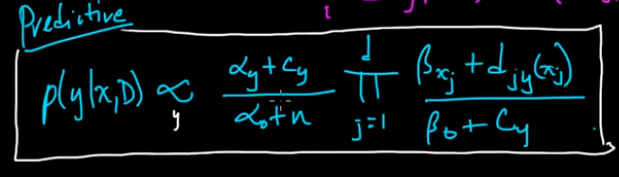

fuente: https://www.youtube.com/watch?v=dBUeoruhYTk

Esta ecuación nos dice que cual la nueva distribución para "y" es equivalente a incluir conteos imaginarios sobre las clases y sobre las frecuencias de las features dada las clase.

A continuación se implementan ambos algoritmos y se procede a analizar sus rendimientos.

## Implementación

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time

from sklearn.model_selection import train_test_split

In [25]:
class NaiveBayes:
    
    def __init__(self):
        # Para calcular p(x_i == d | y = c)
        self.feature_frecuencies = dict()  # Probabilidades de cada feature dada una clase. (dict de dicts de dicts)
                                           # self.feature_frecuencies[class][feature][valor_feature] = frecuencia
                    
        # Para calcular p(y == c)
        self.class_frecuencies = dict()  # Cantidad de datos de cada clase (dict)
        
        self.total_datos = 0  # Cantidad de datos en total (int)  


    def fit(self, X, y):
        
        # Posibles clases y features
        self.clases = list(set(y))
        self.features = list(X)
        
        # Inicializamos valores segun la data
        print("Iniciando...")
        for clase in self.clases:
            self.class_frecuencies[clase] = 0
            self.feature_frecuencies[clase] = dict()
            for feature in self.features:
                self.feature_frecuencies[clase][feature] = dict()

        self.total_datos = X.shape[0]
        
        # Para tomar el tiempo
        t = time()
        i = 1
        
        # Contamos todas las frecuencias que necesitamos, tiempo esperado unos 2 minutos        
        for index, row in X.iterrows():
            if i % 1000 == 0:
                print('Time remaining {:.3f} minutes...'.format(((time() - t) / (i) * (self.total_datos - i)) / 60),  end='\r')
            i += 1
            
            # Contamos las clases
            clase = y[index]
            self.class_frecuencies[clase] += 1
            
            # Para cada feature dada la clase, calculamos la distribucion de frecuencias
            for feature in self.features:
                entrada = row[feature]
                if entrada in self.feature_frecuencies[clase][feature]:
                    self.feature_frecuencies[clase][feature][entrada] += 1
                else:
                    self.feature_frecuencies[clase][feature][entrada] = 1

                

    def predict(self, x, y):
        """ x: Vector de features del dato a predecir, de la clase row de data.iterrows()
            return p(y|x): probabilidad no normalizada de que la clase sea "y" dada las features "x"
        """

        # probabilidad de la clase p(y = clase)
        p_clase = self.class_frecuencies[y] / self.total_datos

        # Cantidad de datos en la clase
        total_given_class = self.class_frecuencies[y]

        # Probabilidad de la clase dado los datos. Se calculará multiplicando de manera acumulativa 
        p_y = p_clase

        # Calculamos p(features | clase) asumiendo independencia entre las features
        for feature in self.features:
            # Almacenamos el valor de la feature
            dato = x[feature]
            
            # Calculamos cuantas veces aparece el valor dada la clase
            frecuencia = self.feature_frecuencies[y][feature][dato] \
                         if dato in self.feature_frecuencies[y][feature] else 0

            # p(x_i | y)
            p_dato_given_class = frecuencia / total_given_class

            # Se acumula la probabilidad calculada multiplicándola
            p_y *= p_dato_given_class
                
        return p_y
                
    
class BayesianNaiveBayes(NaiveBayes):
    
    def __init__(self):
        super().__init__()
        self.alpha = dict()  # self.alpha[clase] = int
        self.alpha_sum = 0
        self.beta = dict()  # self.beta[clase][feature][value] = int
        self.beta_sum = dict()  # self.beta_sum[clase][feature] = int
    
    def fit(self, X, y):
        super().fit(X, y)

        # Almacenamos todos los posibles valores de cada feature.
        self.posible_feature_values = dict()
        for feature in self.features:
            self.posible_feature_values[feature] = set(X[feature])
        
        self.change_priors(10000, 1000)
        
                  
    def predict(self, x, y):
        """ x: Vector de features del dato a predecir, de la clase row de data.iterrows()
            return p(y|x): probabilidad no normalizada de que la clase sea "y" dada las features "x"
        """

        # Hacemos lo mismo que en Non-Bayesian Naive Bayes pero
        # aplicamos conteos imaginarios aquí... 
        p_clase = (self.class_frecuencies[y] + self.alpha[y]) / (self.total_datos + self.alpha_sum)  

        p_y = p_clase
        
        total_given_class = self.class_frecuencies[y]

        for feature in self.features:
            dato = x[feature]
            
            frecuencia = self.feature_frecuencies[y][feature][dato] \
                         if dato in self.feature_frecuencies[y][feature] else 0

            # ...y aquí.
            p_dato_given_class = (frecuencia + self.beta[y][feature][dato]) / (total_given_class + self.beta_sum[y][feature])

            p_y *= p_dato_given_class
                
        return p_y
    
    def change_priors(self, alpha=1000, beta=10):
        
        # Creamos los valores para alpha y beta, suponiendo igual cantidad para todos.
        for clase in self.clases:
            self.alpha[clase] = alpha  # alpha_c
            self.alpha_sum += beta  # alpha_0
            self.beta[clase] = dict()
            self.beta_sum[clase] = dict()
            
            for feature in self.features:
                self.beta[clase][feature] = dict()
                self.beta_sum[clase][feature] = 0
                
                for value in self.posible_feature_values[feature]:
                    self.beta[clase][feature][value] = 1  # Beta_jc
                    self.beta_sum[clase][feature] += 1  # Beta_0

In [15]:
# Leemos los datos
data = pd.read_csv('FATS_OGLE_bin.dat', sep="\t")
print(data.shape)
data.head()

(411672, 8)


,Class,Amplitude,Std,Period,Mean,MaxSlope,Meanvariance,LinearTrend
0,1,6,6,5,17,15,3,11
1,1,3,3,7,18,22,2,10
2,1,4,3,6,18,44,2,11
3,1,2,2,5,9,1,2,10
4,1,2,2,5,15,35,1,11


In [16]:
# Observamos las clases existentes y sus frecuencias
class_counts = data['Class'].value_counts()
class_counts

3    279012
5     45319
1     38719
2     30274
4     10010
0      8338
Name: Class, dtype: int64

In [17]:
# Realizamos muestreo estratificado
X = data[['Amplitude', 'Std', 'Period', 'Mean', 'MaxSlope', 'Meanvariance', 'LinearTrend']]
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=data['Class'])

In [18]:
y_train.value_counts()

3    223209
5     36255
1     30975
2     24219
4      8008
0      6671
Name: Class, dtype: int64

In [19]:
y_test.value_counts()

3    55803
5     9064
1     7744
2     6055
4     2002
0     1667
Name: Class, dtype: int64

## Análisis Comparativo

In [26]:
# Instanciamos al modelo y lo entrenamos
NB = NaiveBayes()
NB.fit(X_train, y_train)

Iniciando...


In [27]:
# Instanciamos al modelo y lo entrenamos
BayesianNB = BayesianNaiveBayes()
BayesianNB.fit(X_train, y_train)

Iniciando...


In [28]:
NB.class_frecuencies

{0: 6671, 1: 30975, 2: 24219, 3: 223209, 4: 8008, 5: 36255}

### Experimento 1

A continuacion se calculará que tan bueno son los algoritmos, calculando sus matrices de confusion

In [35]:
def confusion_matrix(model, X_test, y_test):
    
    # Inicializamos la matriz
    matrix = [[0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0]]
    
    # Para tomar el tiempo
    i = 1
    t = time()
    test_size = X_test.shape[0]

    # Iteramos sobre los datos para testear el modelo
    for index, row in X_test.iterrows():

        true_class = y_test[index]
        predicted_class = 4
        probability = 0

        # Seleccionamos la clase con mayor probabilidad según la predicción
        for clase in range(6):
            p = model.predict(row, clase)

            if p > probability:
                probability = p
                predicted_class = clase
                
        # Registramos la prediccion en la matriz
        matrix[true_class][predicted_class] += 1
                        
        # Informamos el tiempo cada 1000 iteraciones
        if i % 1000 == 0:
            print('Time remaining {:.3f} minutes...'.format(((time() - t) / (i) * (test_size - i)) / 60),  end='\r')
        i += 1
    
    return matrix

In [37]:
confusion_matrix(NB, X_test, y_test)

[[1652, 0, 0, 0, 0, 15],
 [2, 6111, 764, 591, 207, 69],
 [1, 643, 5174, 71, 103, 63],
 [13, 19, 0, 51660, 0, 4111],
 [0, 101, 70, 38, 1776, 17],
 [134, 19, 16, 768, 0, 8127]]

In [36]:
confusion_matrix(BayesianNB, X_test, y_test)

[[1655, 0, 0, 0, 0, 12],
 [4, 6036, 787, 542, 304, 71],
 [7, 581, 5066, 64, 284, 53],
 [13, 29, 1, 51452, 0, 4308],
 [0, 73, 48, 32, 1835, 14],
 [149, 17, 22, 685, 3, 8188]]

Si miramos la diagonal, podemos ver que el algoritmo bayesiano tiene menos aciertos que el algoritmo tradicional. A continuación trataremos de encontrar una ventaja del algoritmo bayesiano observando el comportamiento a nivel de la distribución de la predicción, en vez del máximo, que sería la clase que se escoge.

### Experimento 2

El segundo experimento consistirá en observar como varia la distribución de probabilidad para la clase predicha. Para esto se hará un gráfico para cada clase real, y se graficará el promedio de las probabilidades predichas para cada clase posible.

Se espera que para cada posible clase, la distribución al ocupar priors se haga menos marcada. Por ejemplo, la probabilidad de que los datos de la clase 0 sean de la clase 0 debería bajar un poco, mientras que la probabilidad de no ser de la clase 0 debiese aumentar. veamos lo que pasa a continuación:

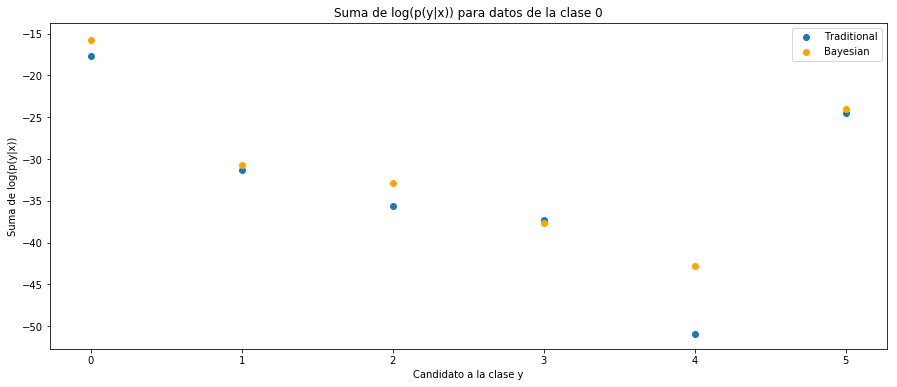

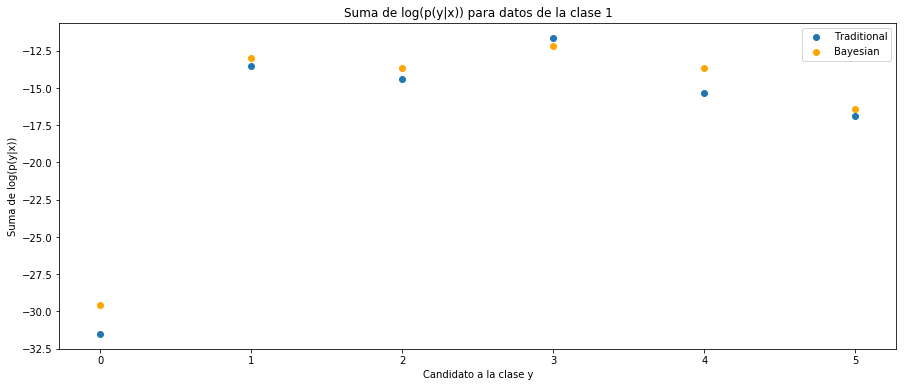

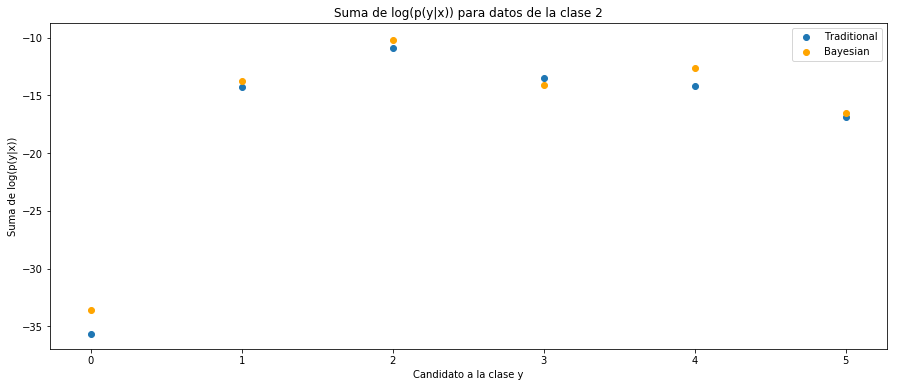

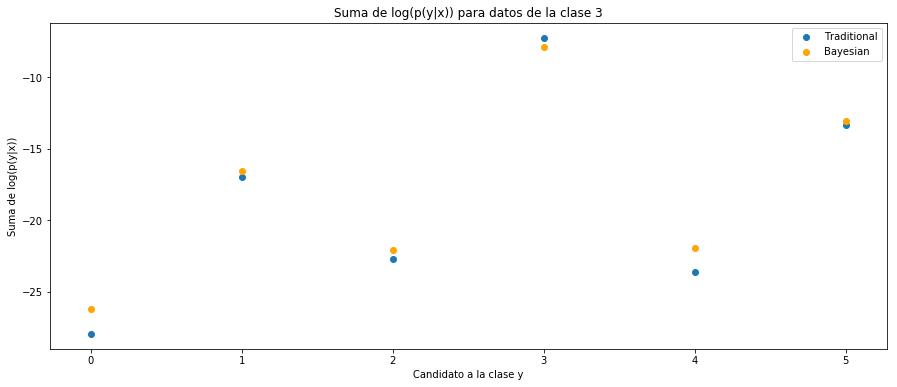

C:\Users\Greg\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


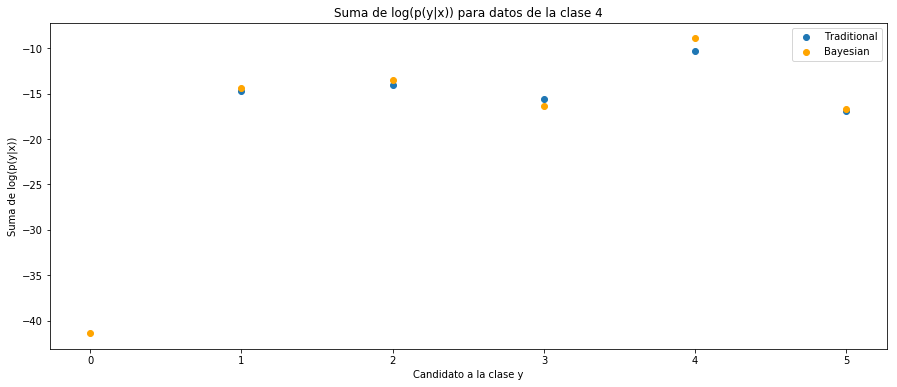

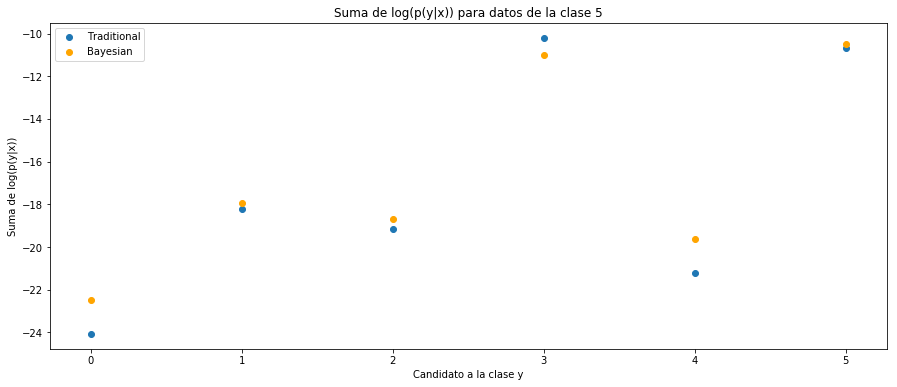

In [43]:
for CLASE in range(6):
    
    sum_probabilities = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    sum_bayesian = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

    BayesianNB.change_priors(alpha=100000, beta=10000)
    for index, row in X_test[y_test == CLASE].iterrows():

        for clase in sum_probabilities:
            sum_probabilities[clase] += NB.predict(row, clase)
            sum_bayesian[clase] += BayesianNB.predict(row, clase)

    frec_clase = y_test.value_counts()[CLASE]
    plt.figure(figsize=(15, 6))
    plt.scatter(sum_probabilities.keys(), [np.log(d/frec_clase) for d in sum_probabilities.values()], label='Traditional')
    plt.scatter(sum_bayesian.keys(), [np.log(d/frec_clase) for d in sum_bayesian.values()], color='orange', label='Bayesian')

    plt.title(f'Suma de log(p(y|x)) para datos de la clase {CLASE}')
    plt.xlabel('Candidato a la clase y')
    plt.ylabel('Suma de log(p(y|x))')
    plt.legend()
    plt.show()

Es posible observar que, efectivamente, ser bayesianos con priors altos no hace estar menos seguros de la predicción, nivelando  las probabilidades de cada posible clase, dado los datos de una clase real específica.

### Experimento 3

A continuación se graficará como cambia el recall de la predicción ocupando distintos valores para los priors de las clases, comparándolo con los valores del algoritmo tradicional.

In [31]:
aciertos = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

i = 1
t = time()
test_size = X_test.shape[0]

for index, row in X_test.iterrows():

    true_class = y_test[index]
    predicted_class = 0
    probability = 0
    
    for clase in aciertos:
        p = NB.predict(row, clase)
        
        if p > probability:
            probability = p
            predicted_class = clase
    
    if true_class == predicted_class:
        aciertos[true_class] += 1
        
    if i % 1000 == 0:
        print('Time remaining {:.3f} minutes...'.format(((time() - t) / (i) * (test_size - i)) / 60),  end='\r')
    i += 1

for key in aciertos:
    aciertos[key] /= y_test.value_counts()[key]

iteracion 0... 
recall: {0: 0.991001799640072, 1: 0.7882231404958677, 2: 0.8525185796862097, 3: 0.9256491586473845, 4: 0.8906093906093906, 5: 0.8966240070609003}
precision: {0: 0.912707182320442, 1: 0.8878545454545455, 2: 0.858187863674148, 3: 0.9724936458627507, 4: 0.8442234848484849, 5: 0.6549806576402321}
iteracion 1... 
recall: {0: 0.9922015596880623, 1: 0.7816373966942148, 2: 0.8426094137076796, 3: 0.9241259430496568, 4: 0.9055944055944056, 5: 0.8978375992939099}
precision: {0: 0.9087912087912088, 1: 0.8930362938920036, 2: 0.8558966616339541, 3: 0.9731652544771754, 4: 0.7910122164048866, 5: 0.6514047866805411}
iteracion 2... 
recall: {0: 0.9928014397120576, 1: 0.7794421487603306, 2: 0.8366639141205615, 3: 0.9220292815798434, 4: 0.9165834165834166, 5: 0.9033539276257723}
precision: {0: 0.9053610503282276, 1: 0.8960807600950119, 2: 0.8551654287643484, 3: 0.9749313121743249, 4: 0.7563891178895301, 5: 0.6474774632294796}


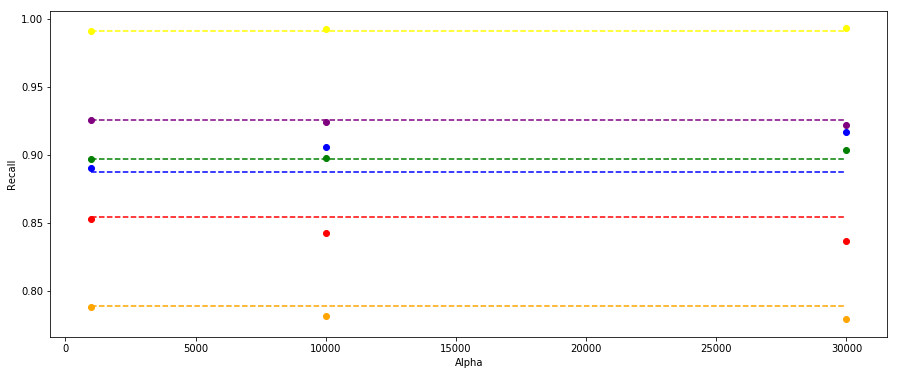

In [34]:
test_size = X_test.shape[0]


alphas = [1000, 10000, 30000]#, 40000, 60000, 80000, 100000]
colors = {0: 'yellow', 1: 'orange', 2: 'red', 3: 'purple', 4: 'blue', 5: 'green'}

plt.figure(figsize=(15,6))
linx = np.linspace(min(alphas), max(alphas), 1000)
for clase in aciertos:
    
    plt.plot(linx, aciertos[clase]*np.ones(len(linx)), color=colors[clase], linestyle='--')

for j in range(len(alphas)):
    
    # Informamos la iteracion
    print(f"iteracion {j}... ")
    
    # Cambiamos los priors sin tener que volver a entrenar el modelo
    BayesianNB.change_priors(alpha=alphas[j])
    
    # Registramos metricas
    true_positives = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    false_positives = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
    false_negatives = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

    # Para tomar el tiempo
    i = 1
    t = time()

    for index, row in X_test.iterrows():

        true_class = y_test[index]
        predicted_class = 0
        probability = 0

        # Seleccionamos la clase con mayor probabilidad según la predicción
        for clase in range(6):
            p = BayesianNB.predict(row, clase)

            if p > probability:
                probability = p
                predicted_class = clase

        # Registramos resultados
        if true_class == predicted_class:
            true_positives[true_class] += 1
        else:
            false_negatives[true_class] += 1
            false_positives[predicted_class] += 1
            
        # Informamos el tiempo cada 1000 iteraciones
        if i % 1000 == 0:
            print('Time remaining {:.3f} minutes...'.format(((time() - t) / (i) * (test_size - i)) / 60),  end='\r')
        i += 1

    
    recall_bayesian = dict()
    precision_bayesian = dict()
    for key in range(6):
        recall_bayesian[key] = true_positives[key] / (true_positives[key] + false_negatives[key])
        precision_bayesian[key] = true_positives[key] / (true_positives[key] + false_positives[key])
        
        plt.scatter(alphas[j], recall_bayesian[key], color=colors[key], label=f"class: {key}")
    
    print("recall:", recall_bayesian)
    print("precision:", precision_bayesian)
        
        
plt.xlabel("Alpha")
plt.ylabel("Recall")
plt.show()

Las lineas punteadas indican el rendimiento para el algoritmo tradicional. Podemos observar que, al aplicar priors, los resultados varian más para las clases 3, 4 y 5 (morado, azul y verde respectivamente). El rendimiento entre estas tres clases tiende a igualarse, esto se debe a que, como el algoritmo bayesiano tiende a nivelar la probabilidad de la prediccion para cada posible clase, los casos en los que estas 3 clases tienen probabilidades parecidas ocurre que la prediccion puede cambiar, ya que cambia la clase que obtiene la máxima probabilidad.

Podemos observar tambien que la clase 0 (amarilla), casi no cambia su rendimiento. Esto se debe a que el algoritmo en general esta muy seguro a la hora de distinguir esta clase, por lo que los priors no alcanzan a hacer un cambio de opinion por parte de la predicción.